# **NEURAL STYLE TRANSFER ON IMAGE WITH BACKGROUND RETAINED**
## **INTRODUCTION-**
# The project aims at transferring a style image on the face of a person while retaining the background as it is.The person's image(content_image)+ abstract image(style_image)= face of person stylized(new_stylized image).
# The issue with running a simple neural model for this problem is that the background isn't retained as it is.So the solution  to this is given the foreground extraction and segmentation also known as foreground-background extraction.
# **MODEL-**
# The first part is running the neural style transfer model on the content and style image to give the stylized image without the background retained.
# The next part is extraction of background from the content image and foreground form the stylized_image adding both the of them together to give the stylized_image with background retained as it is.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [ ]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from PIL import Image
from torchvision import models

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

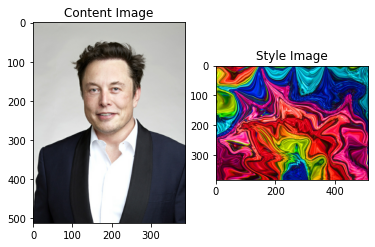

In [ ]:
content_image = load_img("/content/elon_musk_portrait.jpeg")   #upload the image and then select the path to the content image(person's face)
style_image = load_img("/content/abstract_pattern.jpeg")  #upload the image and then select the path to the style image(abstract painting)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')  #loading pretained model from tensorflow 
                                                                                                #for stylized image generation
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

In [ ]:
def tensor_to_image(tensor):     #converting tensor to image
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

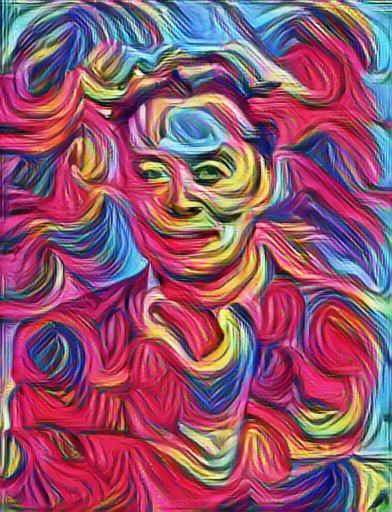

In [ ]:
tensor_to_image(stylized_image) #output of the above model is a tensor so converting it to an image

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
tensor_to_image(stylized_image).save(fp="flashy.jpg")

# **TRAINING MODEL ON OWN**

In [ ]:
import torchvision

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('suit', 0.79664665),
 ('Windsor_tie', 0.12970811),
 ('groom', 0.038668428),
 ('bow_tie', 0.008424286),
 ('Loafer', 0.0036174806)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  747.35284
  mean:  46.432346

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  5166.267
  mean:  231.37608

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  10332.034
  mean:  289.0992

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  26644.34
  mean:  942.02606

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  4736.9336
  mean:  80.56745



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0012143959
    max:  64399.43
    mean:  384.1499

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  92987.45
    mean:  11387.182

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  211229.22
    mean:  10928.346

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1802777.0
    mean:  151351.9

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  217540.95
    mean:  1518.7821

Contents:
   block5_conv2
    shape:  (1, 32, 24, 512)
    min:  0.0
    max:  1707.9917
    mean:  13.23169


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-4
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

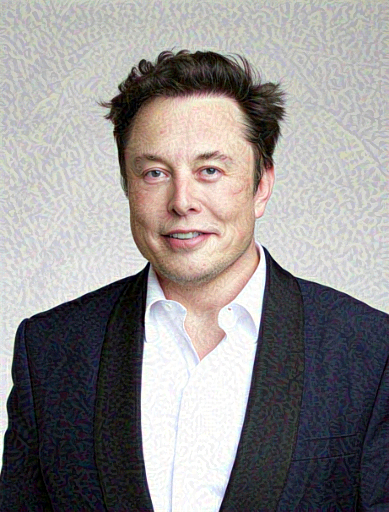

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
import time
start = time.time()

epochs = 7
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  # display.clear_output(wait=True)
  # display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
Total time: 56.5


In [ ]:
tensor_to_image(image).save(fp="flashy.jpg")

In [ ]:
#Define the helper function

def decode_segmap(image, nc=21):
  label_colors = np.array([(255, 255, 255),  # 0=background
                           # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                           (128, 0, 0), (0, 128, 0), (255, 255, 255), (0, 0, 128), (128, 0, 128),
                           # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                           (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
                           # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
                           (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (0, 0, 0),
                           # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
                           (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])  #setting the pixel values for the segmented
#image . Not required to set the values for all the labels. Here pixel values for background are set to (0,0,0) and person (255,255,255).
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
def segment(net, path, show_orig=True,dev='cuda'):
  img = Image.open(path)
  if show_orig: 
   plt.imshow(img); 
   plt.axis('off'); 
   plt.show()
# The preprocessing of image is done and converted to a tensor and then normalized.The normalizing part can be commented.
  trf = T.Compose([T.ToTensor(),
  T.Normalize(mean = [0.485, 0.456, 0.406],
  std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  return rgb

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

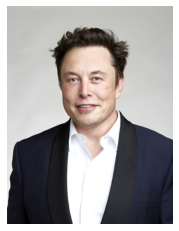

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
rgb=segment(dlab, "/content/elon_musk_portrait.jpeg")

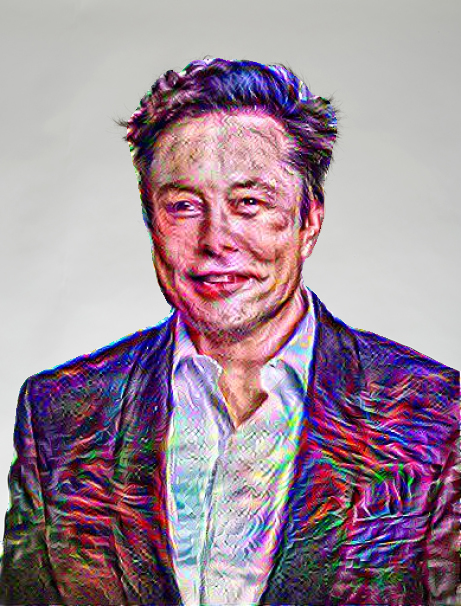

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#alpha blending to customize the background of the image
# Read the images
foreground = cv2.imread("/content/elon_musk_portrait.jpeg")
background = cv2.imread("/content/flashy.jpg", cv2.IMREAD_COLOR)
background = cv2.resize(background, (rgb.shape[1],rgb.shape[0]), interpolation = cv2.INTER_AREA)
alpha = rgb  #maximum pixel values for background and 0 for person's image.
# Convert uint8 to float
foreground = foreground.astype(float)
background = background.astype(float)
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255  #after multiplication intensity values should be between (0,255)
# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background.
outImage = cv2.add(foreground, background) #adding the images together.
# Display image
cv2_imshow(outImage)
cv2.waitKey(0)
# Save/download image
cv2.imwrite('org_plus_cust_bkg_img.png' , outImage)
files.download('org_plus_cust_bkg_img.png') #downloads the image files.